# RooFit Modelling

A quick guide on how to use the `RooFit` module to perform fits.

Load the `Minuit2` module.
We will also use the `Distributions`, `FHist` and `Plots` modules to define cost functions
and display results.

In [1]:
using Revise
using Minuit2
using Minuit2.RooFit        # Load the RooFit module
using Plots                 # Plotting
theme(:boxed)

## RooFit Modelling
The `RooFit` module is a powerful tool for defining and fitting models to data.
It is based on the RooFit library from CERN and provides a Julia interface to it.

Lets by something simple. We will define a model with a single Gaussian distribution and fit it to some data.

In [2]:
x = RealVar(:x, 0., limits=(-5., 5.)) # Create a RooRealVar for x
μ = RealVar(:μ, 0., limits=(-5., 5.)) # Create a RooRealVar for μ
σ = RealVar(:σ, 1., limits=(0.1, 5.)) # Create a RooRealVar for σ
gaus = Gaussian(:gaus, x, μ, σ) # Create a RooGaussian PDF

Gaussian{gaus} PDF with parameters [:μ, :σ]

We can just plot the PDF with the default parameters.

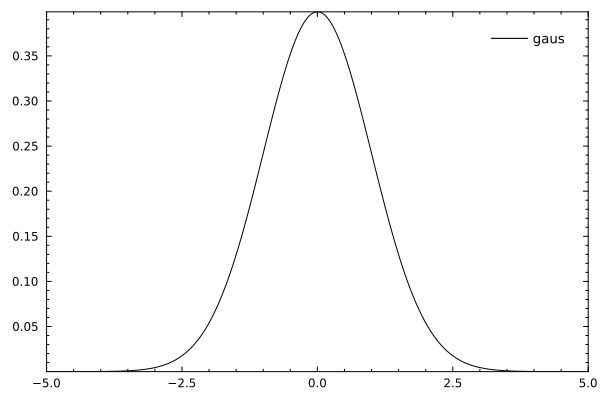

In [3]:
plot(gaus)

which is equivalent to the following code:
```julia
plot(x->gaus(x), x.limits..., label="gaus")
```

Lets now generate some data from the PDF.

In [4]:
data = generate(gaus, 1000); # Generate 1000 observations from the model PDF

Lets fit the data with an `UnbinnedNLL` cost function. It returns a `Minuit` object.

In [5]:
m = fitTo(gaus, data)

FitResult(DataSet{Float64, 1}([2.3926297891366746, -0.4510673761677187, -0.15050562162039544, 0.5406573256779689, -1.400533529250529, -0.7725073890465275, 0.166735906223204, -1.5244849382771783, 0.9636293671671261, 0.8216552254635531  …  1.7072397841735716, 1.3620082663921882, -1.979610022749, 1.1330090216283766, -0.4334390906087991, 1.2679077694990937, -0.2785311837188012, -0.16944934858441105, 1.7006025799189628, 0.03995007010827922], (RealVar{Float64}(:x, 0.0, 0.0, (-5.0, 5.0), 0, false),)), Gaussian{gaus} PDF with parameters [:μ, :σ])

Lets now plot the data and the PDF with the fitted parameters.

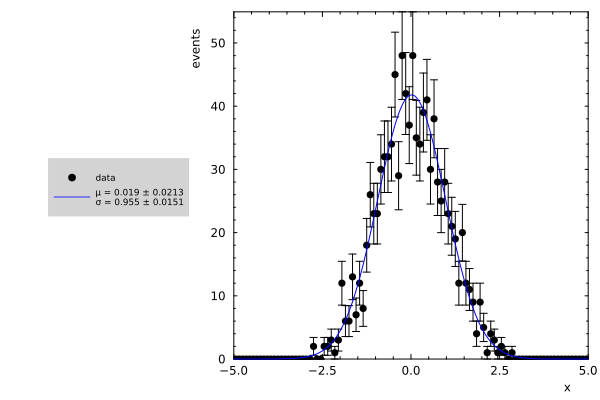

In [6]:
plot(m)

## Combining several PDFs to create a model
Here is a first example of model defined in RooFit that is subsequently used for event generation, an
unbinned maximum likelihood fit and plotting.

### Define the model
We define a model with a signal distribution (gaussian) and a background distribution (argus BG) combining
them with the number of events in each category.

In [14]:
##---Observable
mes =  RealVar(:mes, 0.0, limits=(5.20, 5.30), nbins=50)

##---Gaussian signal
sigmean = RealVar(:sigmean, 5.28, limits=(5.20, 5.30))
sigwidth = RealVar(:sigwidth, 0.0027, limits=(0.001, 0.1))
sig = Gaussian(:sig, mes, sigmean, sigwidth)

##---Build Argus background
argpar = RealVar(:argpar, -20.0, limits=(-100., -1.))
argus = ArgusPdf(:argus, mes, ConstVar(:m₀, 5.291), argpar)

##---Build the model
nsig = RealVar(:nsig, 200., limits=(0., 10000.))
nbkg = RealVar(:nbkg, 800., limits=(0., 10000.))
model = AddPdf(:model, [sig, argus], [nsig, nbkg])

##--- Generate a toyMC sample from composite PDF ---
data = generate(model, 2000)

##--- Perform extended NLL fit ---
result = fitTo(model, data)

FitResult(DataSet{Float64, 1}(edges: [5.2, 5.202, 5.204, 5.206, 5.208, 5.21, 5.212, 5.214, 5.216, 5.218  …  5.282, 5.284, 5.286, 5.288, 5.29, 5.292, 5.294, 5.296, 5.298, 5.3]
bin counts: [48.0, 32.0, 42.0, 42.0, 33.0, 38.0, 38.0, 37.0, 35.0, 32.0  …  131.0, 78.0, 38.0, 25.0, 12.0, 1.0, 0.0, 0.0, 0.0, 0.0]
total count: 2000.0, (RealVar{Float64}(:mes, 0.0, 0.0, (5.2, 5.3), 50, false),)), AddPdf{sig, argus} PDF with parameters [:sigmean, :sigwidth, :argpar, :nsig, :nbkg])

### Visualize the results
The `visualize` function is used to plot the results of the fit. It takes the `Minuit` object as input
and plots the data, the model and the fit results.

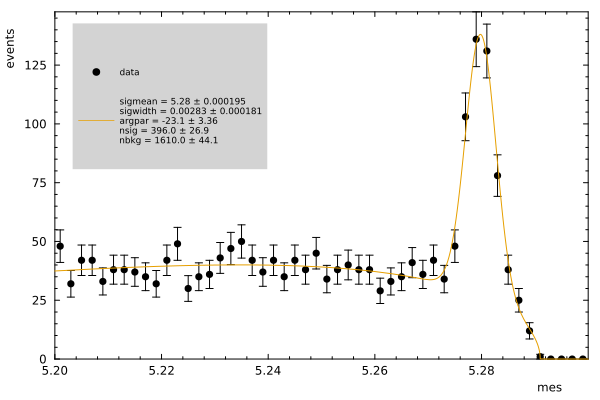

In [46]:
plot(result; legend=:topleft)

We can also visualize the different components of the model overlaid on the data.

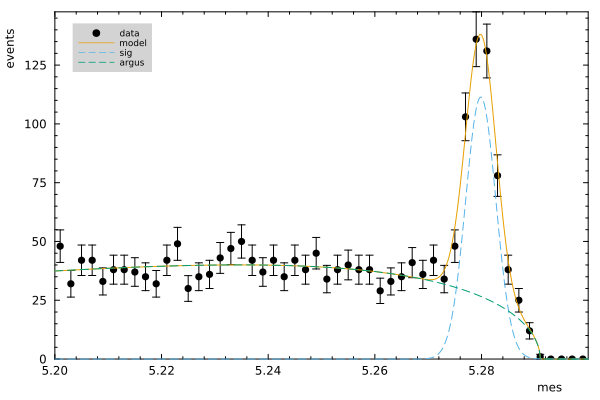

In [49]:
plot(result, components=(:sig, :argus), legend=:topleft)

## Combining several PDFs to create a model sharing some variables
We define a model with two signal distributions and a background distribution.
The model is defined as:

$\text{pdf} = f_{\text{bkg}} \times \text{bkg}(x,c) + (1-f_{\text{bkg}}) \times (f_{\text{sig1}} \times \text{sig1}(x,m_1,s_1) + (1-f_{\text{sig1}}) \times \text{sig2}(x,m_2,s_2)) $

where:
- `c` is the parameter of the background distribution,
- `μ`, `σ1`, and `σ2` are the parameters of the signal distributions,
- `f_sig1` and `f_bkg` are the fractions of the signal and background distributions.

In [73]:
# Define the observable
x =  RealVar(:x, 0., limits=(0., 10.))

# Define the two signals with different widths
μ = RooFit.RealVar(:μ, 3., limits=(0., 5.))
σ1 = RooFit.RealVar(:σ1, .3, limits=(0., 3.))
σ2 = RooFit.RealVar(:σ2, 1., limits=(0., 3.))
sig1 = RooFit.Gaussian(:sig1, x, μ, σ1)
sig2 = RooFit.Gaussian(:sig2, x, μ, σ2)

# Define the background as an exponential function
c = RooFit.RealVar(:c, -0.5, limits=(-0.8, -0.2))
bkg = RooFit.Exponential(:bkg, x, c)

# Define the model as the sum of the two signals and the background
# The background is multiplied by a factor f_bkg, and the first signal by f_sig1
f_bkg = RooFit.RealVar(:f_bkg, 0.4, limits=(0., 1.))
f_sig1 = RooFit.RealVar(:f_sig1, 0.5, limits=(0., 1.))
model =  RooFit.AddPdf(:model, [bkg, sig1, sig2], [f_bkg, f_sig1])

AddPdf{bkg, sig1, sig2} PDF with parameters [:c, :μ, :σ1, :σ2, :f_bkg, :f_sig1]

Lets now generate some data

In [77]:
N = 2000
data = RooFit.generate(model, N);

### Fit the data with UnbinnedNLL
For this example, we will use the `UnbinnedNLL` cost function to fit the data.
We will use the `Minuit` optimizer to minimize the cost function.

In [79]:
result = fitTo(model, data)

FitResult(DataSet{Float64, 1}([5.223796753152466, 0.7362931188838637, 2.5210379916009127, 0.7859143708240367, 0.05085804084424375, 1.2633013305032113, 0.8251709276462359, 0.9476746948809956, 6.455620290437481, 2.2172205456801426  …  3.0739919373886124, 3.1028078717961205, 3.2035431758914656, 4.1943264673565945, 2.427687056117398, 3.6576770053280008, 3.414492308506375, 2.6534035463488896, 2.3810467669602056, 2.2656235038541626], (RealVar{Float64}(:x, 0.0, 0.0, (0.0, 10.0), 0, false),)), AddPdf{bkg, sig1, sig2} PDF with parameters [:c, :μ, :σ1, :σ2, :f_bkg, :f_sig1])

Visualize the results the results and the different components of the model. The `pdf` needs to be
scaled to the number of events in the data and the bin widths and this is done automatically

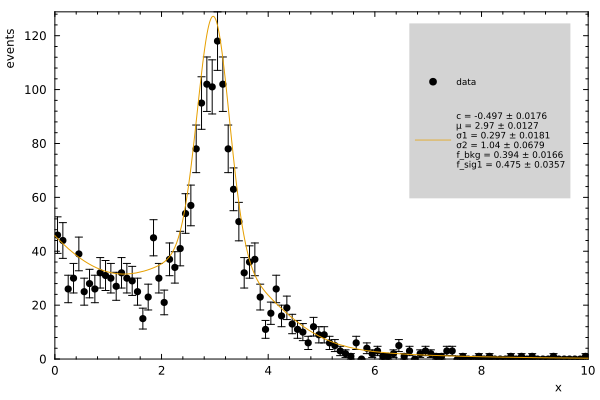

In [82]:
plot(result, legend=:topright)

We can also visualize the components of the overall model

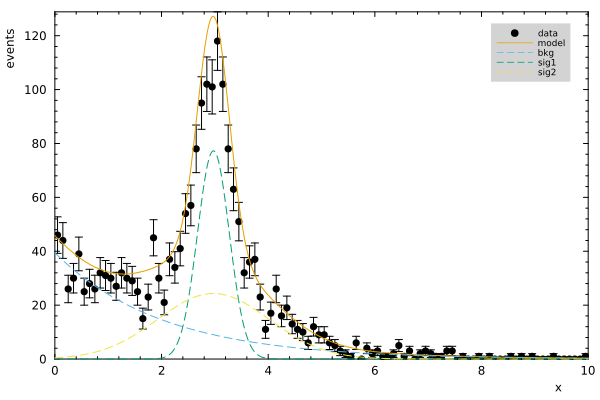

In [83]:
plot(result, components=[:bkg, :sig1, :sig2], legend=:topright)

### Fit the data with BinnedNLL
We do the same but this time using a binned cost function. We generate a histogram with the default
number of bins defined in the variable `x`.

In [127]:
N = 2000
data = RooFit.generate(model, N, nbins=20);

The generated `data` in this case is directly an `Hist1D` object.

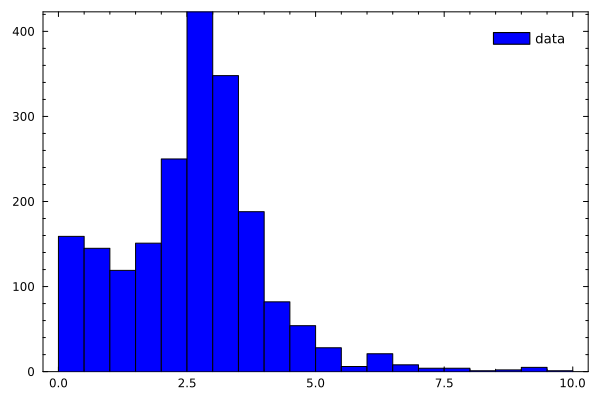

In [128]:
plot(data.data, label="data", c=:blue)

and fit the data with the `BinnedNLL` cost function.

In [129]:
result = fitTo(model, data)

FitResult(DataSet{Float64, 1}(edges: [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5  …  5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0]
bin counts: [159.0, 145.0, 119.0, 151.0, 250.0, 423.0, 348.0, 188.0, 82.0, 54.0, 28.0, 6.0, 21.0, 8.0, 4.0, 4.0, 1.0, 2.0, 5.0, 1.0]
total count: 1999.0, (RealVar{Float64}(:x, 0.0, 0.0, (0.0, 10.0), 0, false),)), AddPdf{bkg, sig1, sig2} PDF with parameters [:c, :μ, :σ1, :σ2, :f_bkg, :f_sig1])

Visualize the results together with the components

In [130]:
[model[i] for i in 1:3]

3-element Vector{Tuple{AbstractPdf, Float64}}:
 (Exponential{bkg} PDF with parameters [:c], 0.355691482664494)
 (Gaussian{sig1} PDF with parameters [:μ, :σ1], 0.3585141553958944)
 (Gaussian{sig2} PDF with parameters [:μ, :σ2], 0.2857943619396116)

bins = 20
plot_attributes = Dict{Any, Any}(:integral => 999.5, :bins => 20)
scale = 999.5
pdf_int = 1


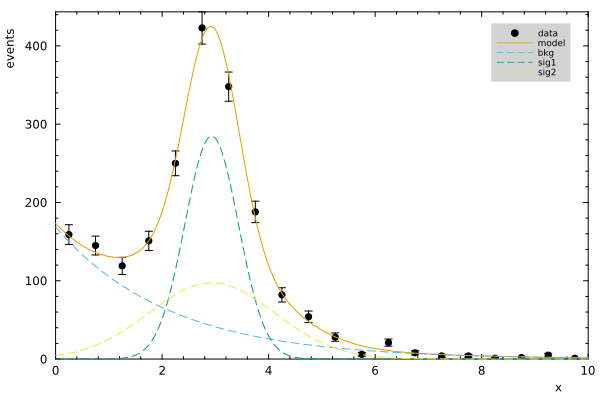

In [132]:
plot(result, components=[:bkg, :sig1, :sig2], legend=:topright)

Finally we can also show the profile of the likelihood for the parameters of interest.
The `draw_mncontour` function is used to plot the contours of the likelihood function in the parameter space.

In [ ]:
draw_mncontour(result.engine, :c, :μ)

MethodError: MethodError: no method matching draw_mncontour(::FitResult, ::Symbol, ::Symbol)
The function `draw_mncontour` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  draw_mncontour(!Matched::Minuit, ::Any, ::Any; cl, size, kwargs...)
   @ Minuit2PlotsExt ~/Development/Minuit2.jl/ext/Minuit2PlotsExt.jl:30


---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*